## Waste Water Plots for Jake ##

In [64]:
import cmocean.cm as cm
import copy
import matplotlib.pyplot as plt
import xarray as xr

from salishsea_tools import viz_tools

In [63]:
# mesh mask file for land mask
meshmask = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
tmask = meshmask.tmask[0]

In [77]:
# make land versions of cmaps, land is grey
cm_salt = copy.copy(cm.haline)
cm_salt.set_bad('grey')
cm_bwr = copy.copy(cm.balance)
cm_bwr.set_bad('grey')
cm_temp = copy.copy(cm.thermal)
cm_temp.set_bad('grey')

In [5]:
## No outfall file
base = xr.open_dataset('/data/sallen/results/MEOPAR/wastewater/base_again/SalishSea_1h_20230301_20230301_grid_T.nc')

In [6]:
## With clean freshwater outfall
tands = xr.open_dataset('/data/sallen/results/MEOPAR/wastewater/tands//SalishSea_1h_20230301_20230301_grid_T.nc')

In [75]:
## plan view 
def planview(base, new, field, it, ide, cmap, vmax, vmin, dvmax):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    iz = 30  # width of domain plotted
    
    base[field][it, ide, 400+iz:500-iz, 250+iz:350-iz].where(
        tmask[ide, 400+iz:500-iz, 250+iz:350-iz]).plot(ax=axs[0], cmap=cmap, vmax=vmax, vmin=vmin)
    axs[0].set_title(f'Base {field}')

    new[field][it, ide, 400+iz:500-iz, 250+iz:350-iz].where(
        tmask[ide, 400+iz:500-iz, 250+iz:350-iz]).plot(ax=axs[1], cmap=cmap, vmax=vmax, vmin=vmin)
    axs[1].set_title(f'New {field}')
    
    (new[field][it, ide, 400+iz:500-iz, 250+iz:350-iz]-
     base[field][it, ide, 400+iz:500-iz, 250+iz:350-iz]).where(
        tmask[ide, 400+iz:500-iz, 250+iz:350-iz]).plot(ax=axs[2], cmap=cm_bwr, 
                                                              vmax=dvmax, vmin=-dvmax)
    axs[2].set_title(f'Difference (New-Base) {field}')

    for ax in axs:
        viz_tools.set_aspect(ax)

    fig.suptitle(f'Depth {base.deptht[ide].values:.0f} m')

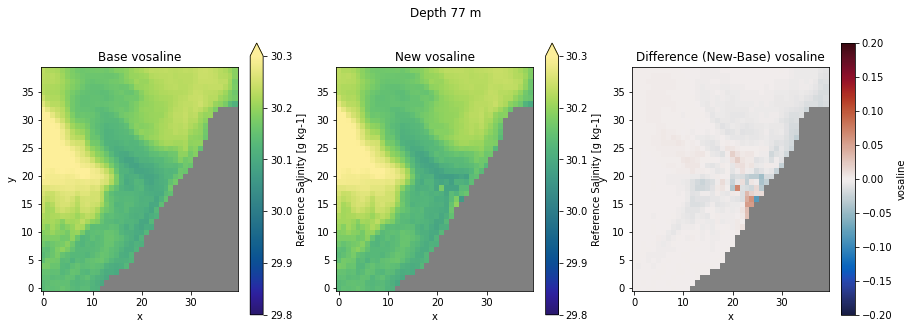

In [76]:
planview(base, tands, 'vosaline', 23, 25, cm_salt, 30.3, 29.8, 0.2)

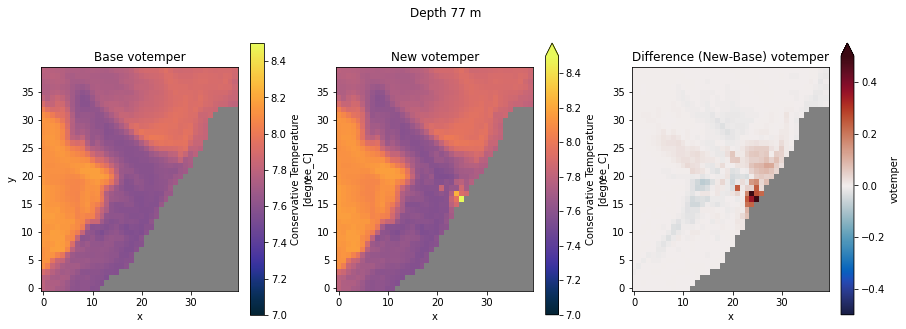

In [78]:
planview(base, tands, 'votemper', 23, 25, cm_temp, 8.5, 7, 0.5)